In [1]:
#import needed libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy.optimize import curve_fit
from scipy.linalg import svd
from sklearn.decomposition import PCA
import math
from numpy import diag
from sklearn.decomposition import TruncatedSVD

process the file
    first  we convert every number into a numeric element -> for that I cannot modify the file itself, so I have to create another 
    object that I can freely edit in order to achieve that.
    once I have an array with all the data I "clean" the data (1656 column, 2000-1800 panxa)

In [141]:


#ALL THE NEEDED FUNCTIONS:



columnas_grupo = ['Grupo', 'Tejido', 'Tiempo', 'Muestra']


#function for creating the panda array from the ascii file
def create_panda_array(pathfile): #filename, path
    #pathfile = path+filename
    #open the data file
    data = open(f'{pathfile}', 'rt')
    
    filename = pathfile.split('\\')
    filename= filename[-1]

    fields = filename.split('_')
    grupo = fields[0]
    tejido = fields[1]
    tiempo = fields[2]
    muestra = fields[3]
    muestra = muestra.split('.')
    muestra = muestra[0]
    

    #create the array for storing the data. I have to know the dimensions of the data before creating the array.
    rows = 0
    for line in data: 
        rows +=1
        line = line.strip('\n')
        line = line.split(',')
        if rows == 1:
            cols = len(line)

#añado 4 columnas para indicar en cada muestra: tejido, grupo, tiempo y nº de la muestra (además incluyo el nombre con el que viene
            #y las wavelengths) (una fila y una columna menos --> iran como titulos)

    array = np.zeros((rows-1, cols-1))
    indices= []
    columnas = []
    columnas_grupo = ['Grupo', 'Tejido', 'Tiempo', 'Muestra']

    data.seek(0)
    n_line = 0
    n_indexes = 0
    for line in data:
        n_line +=1
        line = line.strip('\n')
        line = line.split(',')
        #la primera linea ira directamente, pq son los wavelengths de cada medida. Ademas, añadimos los titulos de los valores añadidos
        # (grupo, tejido, tiempo y muestra)

        if n_line==1:
            n_element = 0
            
            for element in line:
                n_element += 1
                if n_element > 1:
                    element=element.strip('"')
                    columnas.append(str(element))
        #para el resto de lineas tengo que primero, quedarme con el nombre de la muestra, y luego añadir cada medida a un array
                    
#ahora en cada muestra tenemos que poner a que grupo pertenece y todo eso, y ya luego ponemos las medidas 
                    #PROBLEMA --> esto no puedo hacerlo directamente en el array, por eso uso panda, he de hacerlo separado y 
                    #luego juntarlo
        else:
            
            n_element=0
            for element in line:
                n_element += 1
                if n_element == 1: #si estoy en la primera linea cojo el nombre del archivo y lo uso como indice de la fila
                    sample = filename.strip('.txt')
                    new_index = sample + '#' + str(n_indexes)
                    indices.append(new_index)
                    n_indexes += 1
                    # element=element.strip('"')
                    # indices.append(str(element))
                else:
                    array[n_line-2, n_element-2] = float(element)
    
    
    DF_grupos = pd.DataFrame(index = indices, columns = columnas_grupo )   
    DF_grupos['Grupo'] = grupo
    DF_grupos['Tejido'] = tejido
    DF_grupos['Tiempo'] = tiempo
    DF_grupos['Muestra'] = muestra
    

    DF_medidas = pd.DataFrame(array, index = indices, columns = columnas)

    DF = pd.concat([DF_grupos, DF_medidas], axis = 1, sort = False)
    return(DF)



#create a function that filters the data in the "1656.553" column

def filter_1656(df):

    filtered_df= df[(df["1656.553"] >= 0.1) & (df["1656.553"] <= 1)]

    filtered_indexes = filtered_df.index

    complete_indexes = df.index 

    removed_indexes = []

    for i in complete_indexes:
        if i not in filtered_indexes:
            removed_indexes.append(i)        


    return(filtered_df, removed_indexes)

#function to write back the dataframe into an ascii file
def write_df(df, filename):
    
    if 'Grupo' in df.columns:
        df_to_print= df.drop(columns=['Grupo', 'Tejido', 'Tiempo', 'Muestra'])
    else:
        df_to_print = df
    ascii_data = df_to_print.to_csv(sep=',', na_rep='m', header= True, index = True, quotechar = '"', quoting= 2)

    with open(filename, 'w', newline= '') as f:
        f.write(ascii_data)


#function for selecting the panza range (only in 1 specified sample). 
def rango_panza_1sample(df, sample):
    df = df.drop(columns=['Grupo', 'Tejido', 'Tiempo', 'Muestra'])
    df_range= df.loc[:, '2001.749': '1799.26']
    df_range_sample = df_range.loc[sample]

    return (df_range_sample)

def rango_panza(df, a, b): #(for all the samples, select range: from a to b)
    ids = df[columnas_grupo]
    df = df.drop(columns=['Grupo', 'Tejido', 'Tiempo', 'Muestra'])
    df_range= df.loc[:, a: b]
    df_range = pd.concat([ids, df_range], axis= 1)
    
    return (df_range)

#create a function to select samples (a list of samples is given to select) from a df

def select_samples(df, samples):
    selected_samples = df.loc[samples]
    return selected_samples

#create a function to exclude samples (a list of samples is given to select) from a df

def exclude_samples(df, samples):
    selected_samples = df.drop(samples)
    return(selected_samples)


#funcion para, del df grande, sacar dos df, uno para los valores aceptados (sin_panza_df) y otro para los rechazados (sus_df)
    #cuales se aceptan y cuales no? a  Eso hay que decidirlo (threshold). 
    #tambien podemos hacer un tercer df, con las muestras a priori aceptadas que tengan la integral mayor, para ver si hemos
    #cometido errores.
    

def sus_area_integral(df, threshold):

    valores_int = {}


    for sample in df.index:
        df_rango_sample = rango_panza_1sample(df, sample)
        x = []
        y = []

        for p in df_rango_sample.index:
            x.append(float(p))

        for v in df_rango_sample.values:
            y.append(float(v))


        x= np.array(x)
        y = np.array(y)


        #Initial guess

        start = (1, 1, 1)

        

        #Curve fitting. #Bound min = 0, param have to be positive

        param, param_cov = curve_fit(quadratic, x, y, p0=start,\

                                 method="lm", maxfev=100000)

        a_opt, b_opt, c_opt = param

        y_opt = quadratic(x, a_opt, b_opt, c_opt)


            #Calculate residuals and R2

        residuals  = y - y_opt

        ssres = np.sum(residuals**2)

        sstot = np.sum((y-np.mean(y))**2)

        r_squared = 1 - (ssres/sstot)

        integral = trapezoid(y_opt, dx=0.1)

        # if integral > 0.05 and integral < 0.1:
        #      plt.plot(x, y_opt)
        #      plt.plot(x, y)
        
        

        #      plt.show()
        #      print(r_squared)
        #      print(integral)
        
        valores_int[sample] = integral


    sorted_valores_int = {k: v for k, v in sorted(valores_int.items(), reverse=True, key=lambda item: item[1])}
    #print(sorted_valores_int)
        #esto es para ver el valor de la integral para cada muestra. De normal no lo necesitamos, pero viene bien para decidir el threshold

    sus_samples = []
    nose_out_samples = []
    nose_in_samples = []
    n_nose = 0
    decidir= {}
    for sample in sorted_valores_int.keys():
        if valores_int[sample] >= threshold:
            sus_samples.append(sample)
        elif valores_int[sample] > (0.05) and valores_int[sample] < (threshold):
                nose_out_samples.append(sample)
                decidir[sample] = valores_int[sample]
        elif n_nose <= 20:
            nose_in_samples.append(sample)
            n_nose += 1


    #panza_df = rango_panza(df)
    #this is if I only want the rango panza (2000-1800)
            

    sus_panza_df = select_samples(df, sus_samples)

    sin_panza_df = df[~df.index.isin(sus_samples)]
    return(sin_panza_df, sus_panza_df)


# Define the quadratic function

def quadratic(x, a, b, c):

    return a*(x*x)  + b*x + c 


#function para coger una porcion aleatoria de un df

def random_df(df, n):
    random_df = df.sample(n = n, replace = False)

    return random_df


#function to create portions of dfs

def print_df_in_chunks(df, x):

    num_samples = len(df)
    start_idx = 0
    n_chunks = 0
   

    while start_idx < num_samples:
        end_idx = min(start_idx + x, num_samples)
        chunk = df.iloc[start_idx:end_idx]
        write_df(chunk, f'E:\Master\TFM-todo\Datos_procesados\porciones\sinpaza_porcion500_WT_01_{n_chunks}.txt')
        start_idx = end_idx
        n_chunks += 1

def print_chunk(df, x):

    num_samples = len(df)
    start_idx = 0
    n = 0

    while n < 1:
        end_idx = min(start_idx + x, num_samples)
        chunk = df.iloc[start_idx:end_idx]
        write_df(chunk, f'E:\Master\TFM-todo\Datos_procesados\porciones\chunk_{x}.txt')
        start_idx = end_idx
        n += 1
    return chunk




#function to apply sav-gol filter
def savgol(df, points):

    columnas_grupo = ['Grupo', 'Tejido', 'Tiempo', 'Muestra']

    buenos_id = df[columnas_grupo]

    buenos_savgol = df.drop(columns=columnas_grupo)

    for index, row in buenos_savgol.iterrows(): 
        
        buenos_savgol.loc[index] = savgol_filter(row, window_length=points, polyorder=3, deriv=2)


    buenos_savgol = pd.concat([buenos_id, buenos_savgol], axis= 1 , sort= False)

    return buenos_savgol


#funcion para elegir muestras segun grupo (a) , tiempo (b) o tejido (c)

def select_rows_by_criteria(df, a, b, c):
    if a != '-' and b != '-' and c != '-': #tengo todo
        selected_rows = df[(df['Grupo'] == a) &(df['Tiempo'] == b) & (df['Tejido'] == c)]

    elif a == '-' and b != '-' and c != '-': #falta a
        selected_rows = df[(df['Tiempo'] == b) & (df['Tejido'] == c)]
    
    elif a != '-' and b == '-' and c != '-': #falta b
        selected_rows = df[(df['Grupo'] == a) & (df['Tejido'] == c)]

    elif a != '-' and b != '-' and c == '-': #falta c
        selected_rows = df[(df['Grupo'] == a) &(df['Tiempo'] == b)]

    elif a == '-' and b == '-' and c != '-': #falta a y b
        selected_rows = df[(df['Tejido'] == c)]

    elif a == '-' and b != '-' and c == '-': #falta a y c
        selected_rows = df[(df['Tiempo'] == b)]

    elif a != '-' and b == '-' and c == '-': #falta b y c
        selected_rows = df[(df['Grupo'] == a)]
    
    return selected_rows
     
#join several dataframes

def join_dfs (dfs, axis): #axis: juntar muestras (uno encima de otro) -> 0, juntar columnas (uno al lado de otro)->1
    n = 0
    for df in dfs:
        if n == 0:
            joint = df
            n = 1
        else:
            joint = pd.concat([joint, df], axis=axis)
    return joint


def back_to_df(original_df, numpy_array):  #funcion para actualizar los datos de un df, tras haber hecho operaciones con ellos en forma de array
    datos = original_df[columnas_grupo]
    df = original_df.drop(columns = columnas_grupo)

    new_df = pd.DataFrame(numpy_array, index= df.index , columns = df.columns)

    new_complete_df = pd.concat([datos, new_df], axis=1, sort = False)
    
    return new_complete_df

#ahora la idea es hacer una funcion que calcule la integral dentro del rango deseado de todas las muestras de un dataframe. 
#Luego, coger los valores y ordenarlos de mayor a menor, para ver que muestras tienen mas, lo que significa que (muy probablemente)
#tienen panza. Luego (si lo quiero automatizar por completo puedo esteblacer un threshold para decidir si una muestra tiene panza o no)
    #Para esto tendria que crear un diccionario e iterar sobre todas las samples del dataframe. Para cada sample:
    # A) cojo el rango panza
    # B) calculo la integral en ese rango
    # C) Guardo el valor de la integral en un diccionario, el cual será: key --> sample, value --> valor de la integral

#function for calculating the integral (area under the line) in the rango panza of all the samples in the df. 

#DONE


#ahora mi idea es quedarme con las muestras que tengan un valor de la integral mayor que x (ver que x usar)
#comprobar si tienen panza o no
    #para esto tendria que hacer otra funcion en la que seleccione del df todas las samples que toquen y las plotee (o escribirlas
    # en ascii y ponerlas en el unscr) y comprobarlo a ojo (con algunas al menos, hasta coger un threshold adecuado)
#y eliminarlas del estudio en caso de que si

#por ultimo plotear todas las que nos quedamos para el estudio a ver si lo hemos hecho bien



In [139]:
#PROCEDURES
path_WT = 'E:\Master\TFM-todo\Datos_Uns_ascii\WT'
path_IL6= 'E:\Master\TFM-todo\Datos_Uns_ascii\IL6'
path_IL10= 'E:\Master\TFM-todo\Datos_Uns_ascii\IL10'

path= 'E:\Master\TFM-todo\Datos_Uns_ascii\TODO'

#iterate over all the files in the folder to create a dataframe with all the files included
n = 0
list_filenames = []

for filename in os.listdir(path):
    #list_filenames.append(filename)
    file_path = os.path.join(path, filename)

    if n == 0:
        n += 1
        big_DF = create_panda_array(file_path)
    else:
        DF = create_panda_array(file_path)
        big_DF = pd.concat([big_DF, DF], sort = False)


#quitar muestras que se desvian mucho del resto

samples_to_exclude_IL6 = ['IL6_CB-GMG_P0_N150#1','IL6_CB-GMG_P0_N150#3', 'IL6_CB-GMG_P0_N150#4', 'IL6_CB-GMG_P0_N150#8', 'IL6_CB-GMG_P0_N150#9', 'IL6_CB-GMG_P0_N150#15', 'IL6_CB-GMG_P0_N150#47', 'IL6_CB-GMG_P28_N102#0', 'IL6_CB-GMG_P28_N102#18', 
                       'IL6_CB-GMG_P21_N143#32', 
                       'IL6_CB-GMG_P7_N75#21', 'IL6_CB-GMG_P7_N75#18', 'IL6_CB-GMG_P7_N75#13', 'IL6_CB-GMG_P7_N75#8',
                       'IL6_CB-GMM_P21_N143#0', 'IL6_CB-GMM_P21_N143#46', 'IL6_CB-GMM_P21_N143#34',
                       'IL6_CB-GMM_P14_N18#28', 
                       'IL6_CB-GMM_P28_N89#12',  
                       'IL6_CB-WM_P28_N102#11', 'IL6_CB-WM_P28_N102#17', 'IL6_CB-WM_P28_N102#38', 'IL6_CB-WM_P28_N102#2',
                       'IL6_CB-WM_P28_N85#26',  
                       'IL6_CB-WM_P21_N143#46',
                       'IL6_BR-GM_P0_N172#30',
                       'IL6_BR-GM_P7_N54#5','IL6_BR-GM_P7_N54#44']

samples_to_exclude_IL10 = ['IL10_CB-GMG_P0_N256#25', 
                           'IL10_BR-WM_P28_N163#45', 
                           'IL10_CB-GMG_P7_N285#46', 'IL10_CB-GMG_P7_N285#7',
                           'IL10_CB-WM_P0_N256#2','IL10_CB-WM_P0_N256#46',
                           'IL10_CB-GMM_P7_N285#46',
                            'IL10_CB-WM_P14_N220#29', 'IL10_CB-WM_P14_N220#10', 
                            'IL10_CB-WM_P14_N183#15',
                            'IL10_CB-WM_P21_215#12', 
                            'IL10_CB-GMG_P28_N994#34', 'IL10_CB-GMG_P28_N994#17']

samples_to_exclude_WT = [ 'WT_BR-GM_P28_N232#42', 
                        'WT_BR-WM_P14_N180#11',
                        'WT_BR-WM_P0_N113#42',
                        'WT_BR-WM_P7_166#11', 'WT_BR-WM_P7_166#20', 'WT_BR-WM_P7_166#16',
                        'WT_CB-GMG_P21_N191#44', 'WT_CB-GMG_P21_N191#38',
                        'WT_CB-GMG_P7_N247#38',
                        'WT_CB-GMG_P28_997#12',
                        'WT_CB-GMM_P7_N248#17',
                        'WT_CB-WM_P21_N191#8', 'WT_CB-WM_P21_N191#42', 'WT_CB-WM_P21_N191#29',
                        'WT_CB-WM_P21_N192#42',
                        'WT_CB-WM_P14_N214#45']


samples_to_exclude = samples_to_exclude_IL10 + samples_to_exclude_IL6 + samples_to_exclude_WT


removed = select_samples(big_DF, samples_to_exclude)

big_DF = exclude_samples(big_DF, samples_to_exclude)



In [140]:
#filtrar muestras (1656 y panza)

#print(big_DF)

#filter the the dataframe in the column 1656
        
#filtered_DF, removed_indexes_1= filter_1656(DF)
big_filtered_DF, removed_indexes= filter_1656(big_DF)

#print(big_filtered_DF)

#filter for panza

sin_panza_df, sus_samples_df = sus_area_integral(big_filtered_DF, 0.1)
#print(sus_samples_df)
#print(sus_samples_df)
#print(big_filtered_DF)

buenos = sin_panza_df

In [84]:
#SAVGOL filter

# buenos_savgol_11 = savgol(buenos, 11)
buenos_savgol = savgol(buenos, 7)


# buenos_savgol_11 = rango_panza(buenos_savgol_11,"3199.326", "950.7341")
buenos_savgol = rango_panza(buenos_savgol,"3199.326", "950.7341")




#write_df(buenos_savgol, 'E:\Master\TFM-todo\Datos_procesados\\buenos_savgol\\buenos_savgol.txt')

In [58]:
#SVD 2: ahora con ayuda (Con TruncatedSVD puedo elegir el nº de dimensiones que cojo)

df_to_svd = buenos_savgol

columnas_grupo = ['Grupo', 'Tejido', 'Tiempo', 'Muestra']

df = df_to_svd.drop(columns=columnas_grupo)

todo_array = df.to_numpy()

X = todo_array


svd = TruncatedSVD(n_components=7, random_state=27)

U = svd.fit_transform(X)

S_lin = svd.singular_values_
S = diag(S_lin)
V = svd.components_


X_ = U.dot(S.dot(V))

buenos_savgol_SVD_7 = back_to_df(buenos_savgol, X_)

In [ ]:
#SVD 2: ahora con ayuda (Con TruncatedSVD puedo elegir el nº de dimensiones que cojo)

df_to_svd = buenos_savgol

columnas_grupo = ['Grupo', 'Tejido', 'Tiempo', 'Muestra']

df = df_to_svd.drop(columns=columnas_grupo)

todo_array = df.to_numpy()

X = todo_array


svd = TruncatedSVD(n_components=16, random_state=27)

U = svd.fit_transform(X)

S_lin = svd.singular_values_
S = diag(S_lin)
V = svd.components_


X_ = U.dot(S.dot(V))

buenos_savgol_SVD_16 = back_to_df(buenos_savgol, X_)

In [ ]:
#SVD 3: ahora con weighting

df_to_svd = buenos_savgol_7

columnas_grupo = ['Grupo', 'Tejido', 'Tiempo', 'Muestra']

df = df_to_svd.drop(columns=columnas_grupo)

todo_array = df.to_numpy()

X = todo_array


svd = TruncatedSVD(n_components=7, random_state=27)

U = svd.fit_transform(X)

S_lin = svd.singular_values_
S = diag(S_lin)
V = svd.components_


X_ = U.dot(S.dot(V))

buenos_savgol_7_SVD = back_to_df(buenos_savgol_7, X_)

3199.326   -0.000154
3197.398   -0.000125
3195.469   -0.000096
3193.541   -0.000067
3191.613   -0.000038
              ...   
958.448     0.013800
956.5195    0.010413
954.5911    0.004273
952.6626   -0.001813
950.7341   -0.006443
Name: IL10_BR-GM_P0_N228#17, Length: 1167, dtype: float64
3199.326   -0.000125
3197.398   -0.000107
3195.469   -0.000089
3193.541   -0.000071
3191.613   -0.000049
              ...   
958.448     0.019027
956.5195    0.034813
954.5911    0.032143
952.6626    0.001028
950.7341   -0.036951
Name: IL10_BR-GM_P0_N228#17, Length: 1167, dtype: float64
[3199.326, 3197.398, 3195.469, 3193.541, 3191.613, 3189.684, 3187.756, 3185.827, 3183.899, 3181.97, 3180.042, 3178.113, 3176.185, 3174.256, 3172.328, 3170.399, 3168.471, 3166.542, 3164.614, 3162.686, 3160.757, 3158.829, 3156.9, 3154.972, 3153.043, 3151.115, 3149.186, 3147.258, 3145.329, 3143.401, 3141.472, 3139.544, 3137.615, 3135.687, 3133.759, 3131.83, 3129.902, 3127.973, 3126.045, 3124.116, 3122.188, 3120.259, 3118.

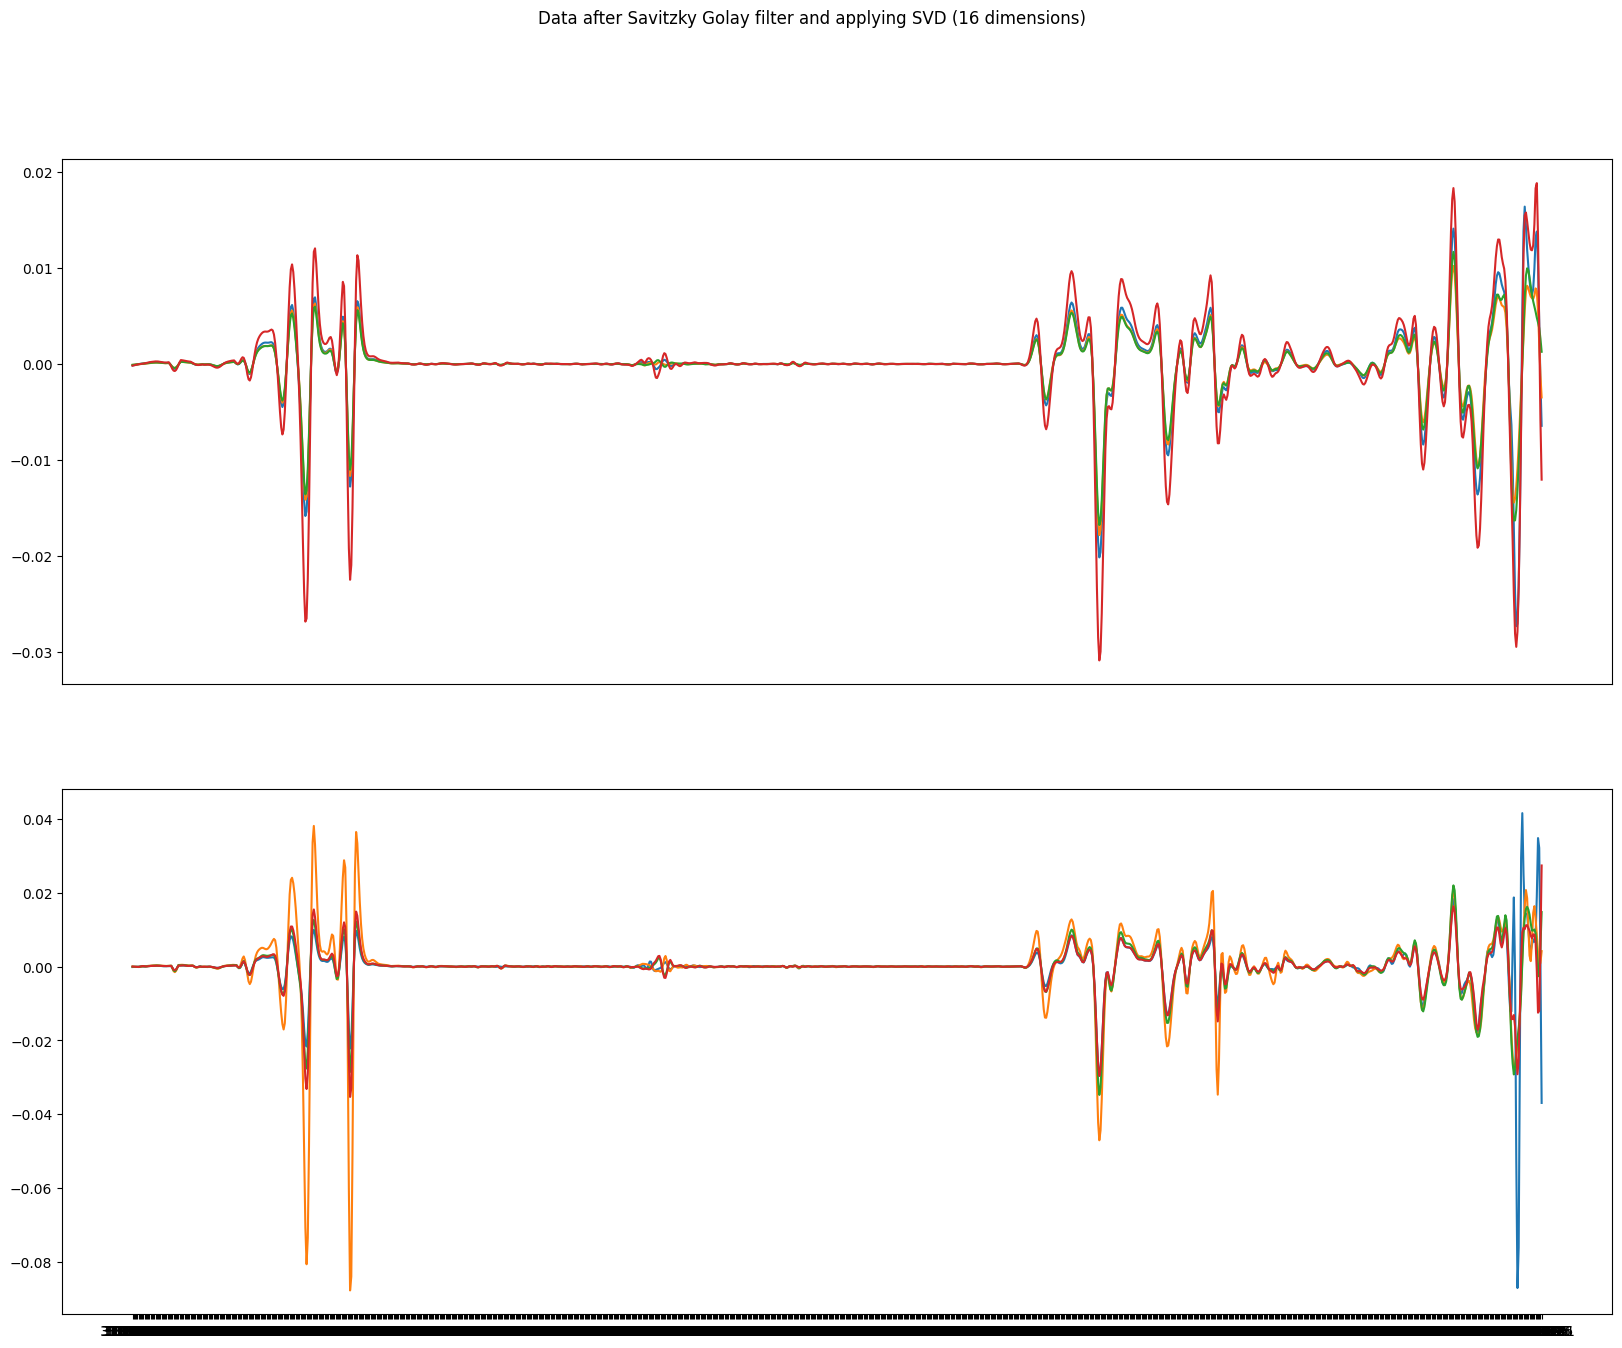

In [87]:
to_plot_11 = buenos_savgol_11_SVD.drop(columns=columnas_grupo)
to_plot_1 = to_plot_11.iloc[65]
print(to_plot_1)
to_plot_2 = to_plot_11.iloc[30]
to_plot_3 = to_plot_11.iloc[59]
to_plot_4 = to_plot_11.iloc[100]

to_plot_7 = buenos_savgol_7_SVD.drop(columns=columnas_grupo)
to_plot_1_ = to_plot_7.iloc[65]
print(to_plot_1_)
to_plot_2_ = to_plot_7.iloc[3000]
to_plot_3_ = to_plot_7.iloc[549]
to_plot_4_ = to_plot_7.iloc[300]


rango=to_plot_11.columns.to_list()

rango_plot = []
for i in rango:
    rango_plot.append(float(i))
print(rango_plot)

fig, (ax1, ax2) = plt.subplots(2, figsize = (20,15))

fig.suptitle('Data after Savitzky Golay filter and applying SVD (16 dimensions)')

ax1.set_xticks(np.arange(3200, 900, 100))
ax1.plot(to_plot_1)
ax1.plot(to_plot_2)
ax1.plot(to_plot_3)
ax1.plot(to_plot_4)

ax2.plot(to_plot_1_)
ax2.plot(to_plot_2_)
ax2.plot(to_plot_3_)
ax2.plot(to_plot_4_)
# ax.set_xticks(np.arange(0, 500, 100))

plt.show()

3199.326    5.160696e-06
3197.398    3.555207e-06
3195.469    1.949717e-06
3193.541    3.442270e-07
3191.613    3.170814e-06
                ...     
958.448     6.902025e-04
956.5195    9.681692e-04
954.5911    7.459171e-04
952.6626    4.085352e-05
950.7341   -6.722357e-04
Name: WT_CB-GMG_P28_997#28, Length: 1167, dtype: float64


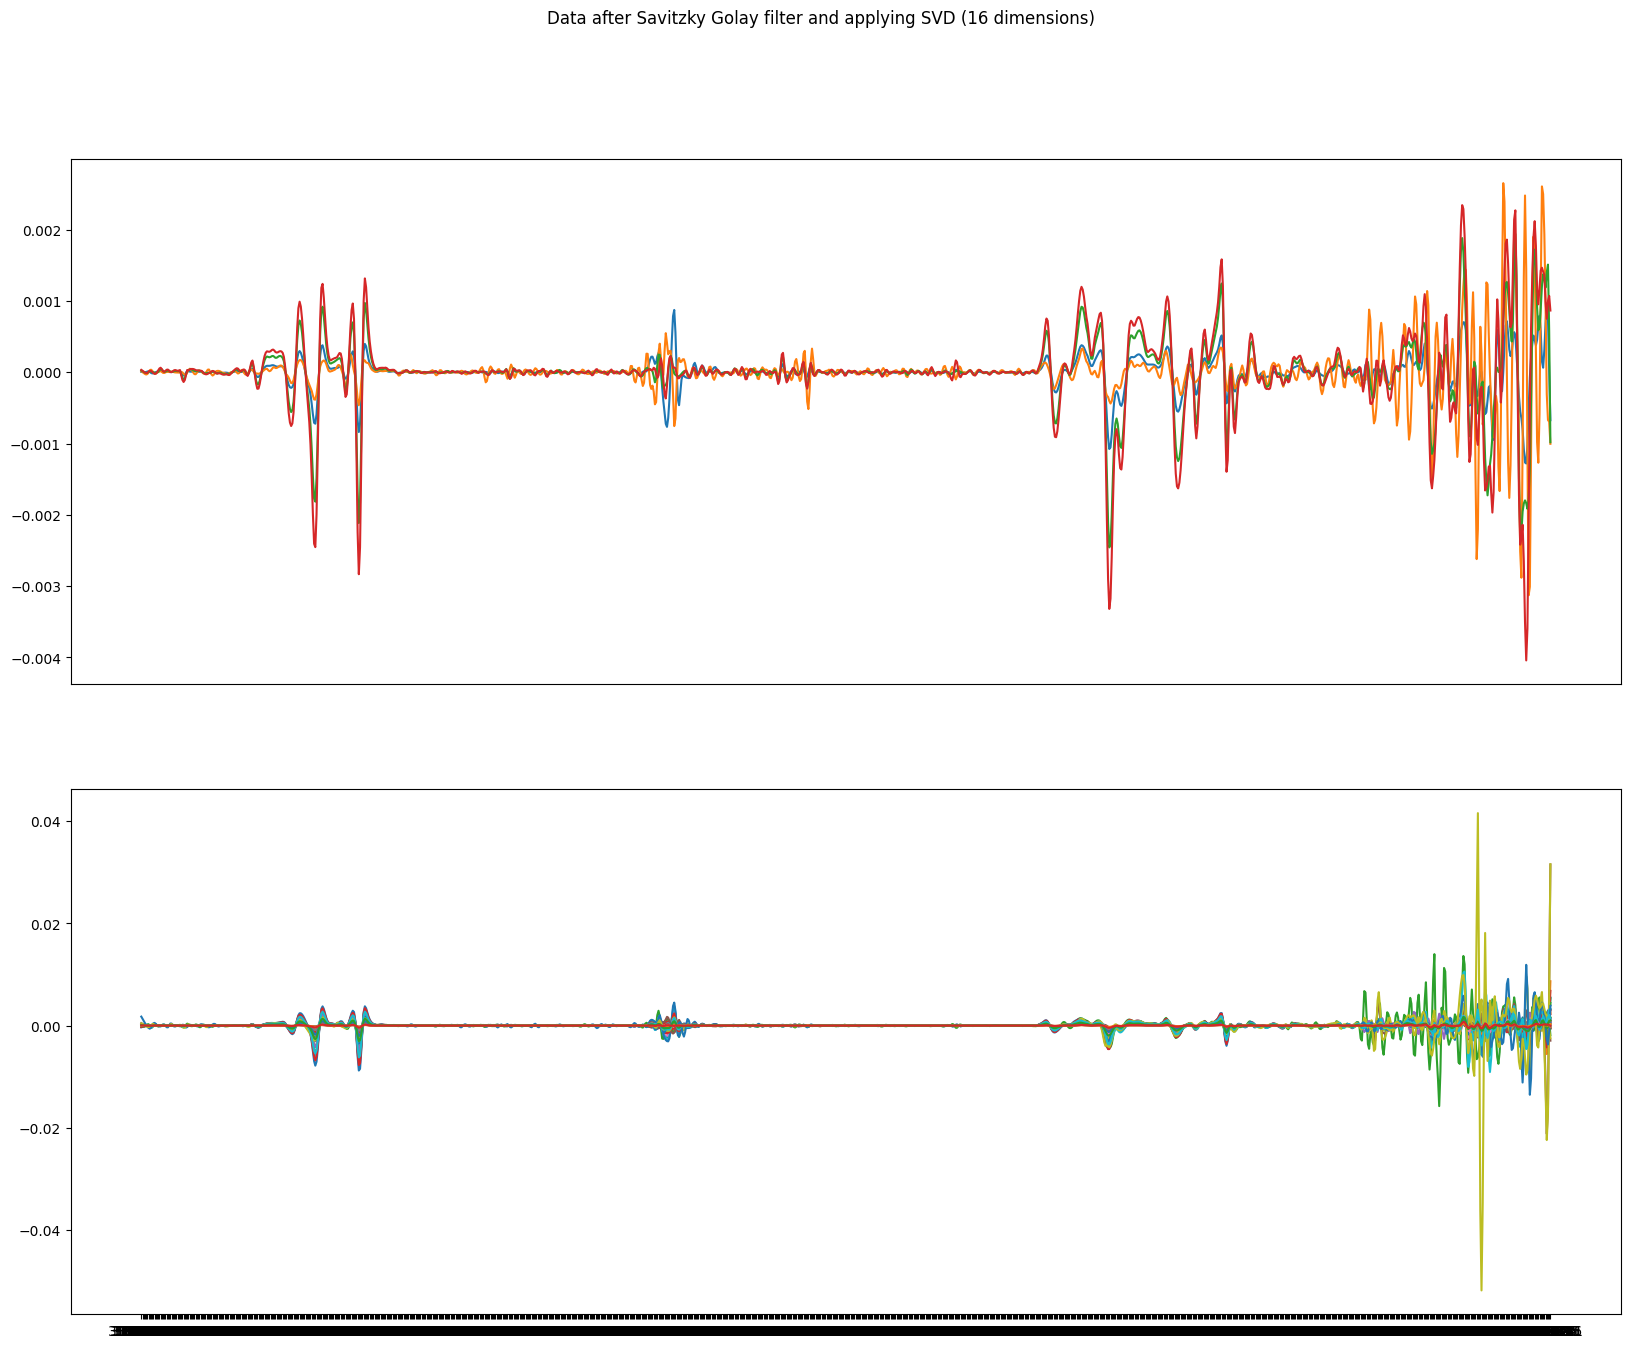

In [92]:
to_plot_11 = sus_savgol_7_SVD.drop(columns=columnas_grupo)
to_plot_1 = to_plot_11.iloc[65]
print(to_plot_1)
to_plot_2 = to_plot_11.iloc[30]
to_plot_3 = to_plot_11.iloc[59]
to_plot_4 = to_plot_11.iloc[100]

removed_savgol_SVD_plot = removed_savgol_SVD.drop(columns=columnas_grupo)

fig, (ax1, ax2) = plt.subplots(2, figsize = (20,15))

for i in range(len(removed_savgol_SVD_plot.index)):
    to_plot = removed_savgol_SVD_plot.iloc[i]
    ax2.plot(to_plot)


rango=to_plot_11.columns.to_list()


fig.suptitle('Data after Savitzky Golay filter and applying SVD (16 dimensions)')

ax1.set_xticks(np.arange(3200, 900, 100))
ax1.plot(to_plot_1)
ax1.plot(to_plot_2)
ax1.plot(to_plot_3)
ax1.plot(to_plot_4)


# ax.set_xticks(np.arange(0, 500, 100))

plt.show()

In [6]:


buenos = exclude_samples(sin_panza_df, samples_to_exclude)
# write_df(buenos, 'E:\Master\TFM-todo\Datos_procesados\\buenos\\buenos_TODO_01.txt')

KeyError: "['IL10_CB-GMG_P0_N256#25', 'IL10_BR-WM_P28_N163#45', 'IL10_CB-GMG_P7_N285#46', 'IL10_CB-WM_P0_N256#2', 'IL10_CB-WM_P0_N256#46', 'IL10_CB-GMM_P7_N285#46', 'IL10_CB-WM_P14_N220#29', 'IL10_CB-WM_P14_N220#10', 'IL10_CB-WM_P14_N183#15', 'IL10_CB-WM_P21_215#12', 'IL6_CB-GMG_P0_N150#1', 'IL6_CB-GMG_P0_N150#3', 'IL6_CB-GMG_P0_N150#4', 'IL6_CB-GMG_P0_N150#8', 'IL6_CB-GMG_P0_N150#9', 'IL6_CB-GMG_P0_N150#15', 'IL6_CB-GMG_P0_N150#47', 'IL6_CB-GMG_P28_N102#0', 'IL6_CB-GMG_P28_N102#18', 'IL6_CB-GMG_P21_N143#32', 'IL6_CB-GMG_P7_N75#21', 'IL6_CB-GMG_P7_N75#18', 'IL6_CB-GMG_P7_N75#13', 'IL6_CB-GMG_P7_N75#8', 'IL6_CB-GMM_P21_N143#0', 'IL6_CB-GMM_P21_N143#46', 'IL6_CB-GMM_P21_N143#34', 'IL6_CB-GMM_P14_N18#28', 'IL6_CB-GMM_P28_N89#12', 'IL6_CB-WM_P28_N102#11', 'IL6_CB-WM_P28_N102#17', 'IL6_CB-WM_P28_N102#38', 'IL6_CB-WM_P28_N102#2', 'IL6_CB-WM_P28_N85#26', 'IL6_CB-WM_P21_N143#46', 'IL6_BR-GM_P0_N172#30', 'IL6_BR-GM_P7_N54#5', 'IL6_BR-GM_P7_N54#44', 'WT_BR-GM_P28_N232#42', 'WT_BR-WM_P14_N180#11', 'WT_BR-WM_P0_N113#42', 'WT_BR-WM_P7_166#11', 'WT_BR-WM_P7_166#20', 'WT_BR-WM_P7_166#16', 'WT_CB-GMG_P21_N191#44', 'WT_CB-GMG_P21_N191#38', 'WT_CB-GMG_P7_N247#38', 'WT_CB-GMG_P28_997#12', 'WT_CB-GMM_P7_N248#17', 'WT_CB-WM_P21_N191#8', 'WT_CB-WM_P21_N191#42', 'WT_CB-WM_P21_N191#29', 'WT_CB-WM_P21_N192#42', 'WT_CB-WM_P14_N214#45'] not found in axis"

In [8]:
#SVD

df_to_svd = buenos_savgol

columnas_grupo = ['Grupo', 'Tejido', 'Tiempo', 'Muestra']

df = df_to_svd.drop(columns=columnas_grupo)

todo_array = df.to_numpy()

X = todo_array

U, s, VT = svd(X)

print(U.shape)
print(len(s))
print(VT.shape)


(10647, 10647)
1193
(1193, 1193)


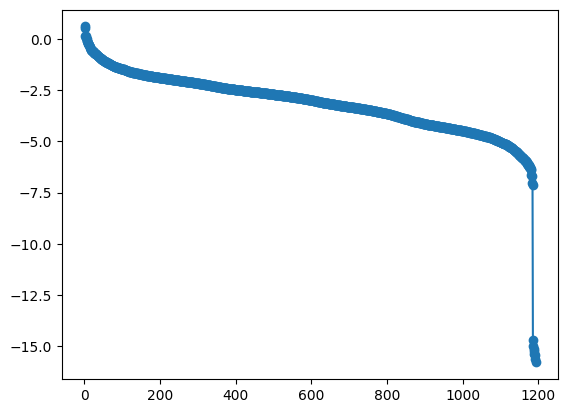

In [9]:
#plotear los sigmas (log)

n_sigma = 0
orden_s = {}
for sigma in s:
    n_sigma += 1
    log_sigma = math.log(sigma, 10)
    orden_s[n_sigma] = log_sigma

x_plot = orden_s.keys()
y_plot = orden_s.values()

plt.plot(x_plot, y_plot, marker = 'o')
plt.show()


In [10]:
#Calculo tau

sigma_med = s[int(len(s)/2)]

beta = (VT.shape[0])/(U.shape[0])

omega = 0.56*(beta*beta*beta) - 0.95*(beta*beta) + 1.82* beta + 1.43

tau = omega*sigma_med

print(tau)

g = 0
for sigma in s:
    if sigma > tau:
        g +=1
    else: 
        print(f'g: {g}')
        break

s_ = []

for sigma in s: 
    if sigma > tau:
        s_.append(sigma)
    else:
        break
print(len(s_))

U_ = U[:, :g]

VT_ = VT[:g, :]

print(U_.shape)
print(VT_.shape)

sigma_ = diag(s_)
s_=np.array(s_)
X_ = U_.dot(sigma_.dot(VT_))
print(X_.shape)

0.0017262716497113155
g: 525
525
(10647, 525)
(525, 1193)
(10647, 1193)


[0.41783116 0.7266558  0.77816201 0.82408491 0.85713951 0.88258423
 0.89884276 0.9132179  0.92412272 0.93335274 0.94101733 0.94725845
 0.9533082  0.95756343 0.96146274 0.96492276 0.96763697 0.96997498
 0.97205063 0.97391394 0.9757123  0.97727802 0.97879431 0.98010076
 0.98134473 0.98240295 0.98341297 0.98439611 0.98531572 0.9861359
 0.98692737 0.98769636 0.98832269 0.98893028 0.98948776 0.99001002
 0.99051632 0.99097527 0.99141434 0.99183437 0.99221587 0.99257486
 0.99290431 0.99321279 0.99350708 0.99378714 0.99404259 0.99428547
 0.99450362 0.9947065  0.99489456 0.99507173 0.99523715 0.99539823
 0.99555627 0.99570818 0.99585254 0.99598194 0.99610888 0.99623162
 0.99634879 0.99646296 0.99657245 0.99667796 0.99677855 0.99687319
 0.99696391 0.99705015 0.997132   0.9972101  0.99728583 0.99735703
 0.99742591 0.99749116 0.99755458 0.9976134  0.99767088 0.99772568
 0.9977785  0.99782878 0.99787858 0.99792671 0.99797372 0.99801972
 0.99806292 0.99810567 0.99814692 0.99818722 0.99822698 0.99826

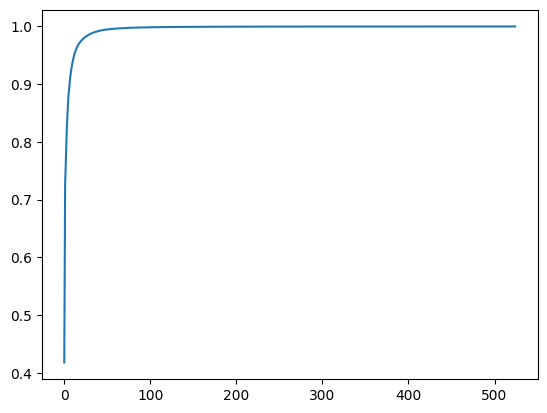

In [11]:
#cantidad de variacion explicada por cada dimension (sola y acumulada)

var_exp= (s_**2)/np.sum(s_**2)
#print(var_exp)

cum_var_exp= np.cumsum(s_**2)/np.sum(s_**2)
print(cum_var_exp)

plt.plot(cum_var_exp)

In [84]:
#SVD 2: ahora con ayuda (Con TruncatedSVD puedo elegir el nº de dimensiones que cojo)

df_to_svd = buenos_savgol

columnas_grupo = ['Grupo', 'Tejido', 'Tiempo', 'Muestra']

df = df_to_svd.drop(columns=columnas_grupo)

todo_array = df.to_numpy()

X = todo_array


svd = TruncatedSVD(n_components=7, random_state=27)

U = svd.fit_transform(X)

S_lin = svd.singular_values_
S = diag(S_lin)
V = svd.components_


X_ = U.dot(S.dot(V))

buenos_savgol_SVD = back_to_df(buenos_savgol, X_)

[0.43302031 0.75307147 0.80645005 0.85404235 0.88829857 0.91466827
 0.93151783 0.94641554 0.95771678 0.96728233 0.97522555 0.98169355
 0.98796322 0.99237314 0.9964142  1.        ]


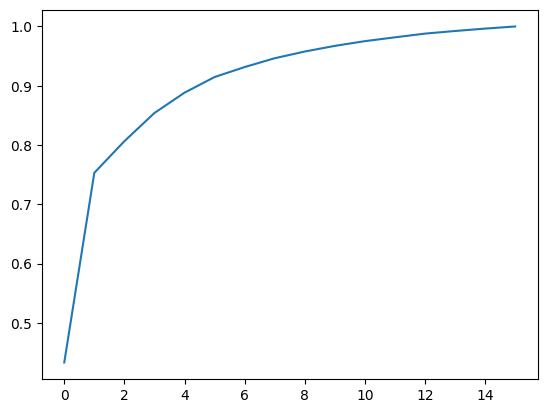

In [65]:
var_exp= (S_lin**2)/np.sum(S_lin**2)
#print(var_exp)

cum_var_exp= np.cumsum(S_lin**2)/np.sum(S_lin**2)
print(cum_var_exp)

plt.plot(cum_var_exp)

                          2516.649
IL10_BR-GM_P0_N227#0  1.884056e-05
IL10_BR-GM_P0_N227#1  6.104746e-06
IL10_BR-GM_P0_N227#2 -8.459090e-06
IL10_BR-GM_P0_N227#3  9.832691e-06
IL10_BR-GM_P0_N227#4  7.355598e-06
...                            ...
WT_CB-WM_P7_N249#43  -1.606116e-06
WT_CB-WM_P7_N249#44  -7.450473e-06
WT_CB-WM_P7_N249#45  -8.888866e-07
WT_CB-WM_P7_N249#46  -2.263330e-06
WT_CB-WM_P7_N249#47  -2.537834e-06

[10647 rows x 1 columns]


{'whiskers': [<matplotlib.lines.Line2D at 0x1f4a2f2e3d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f4a31e0210>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f4a2fcb410>],
 'medians': [<matplotlib.lines.Line2D at 0x1f4a2d59b10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f4a2e45190>],
 'means': []}

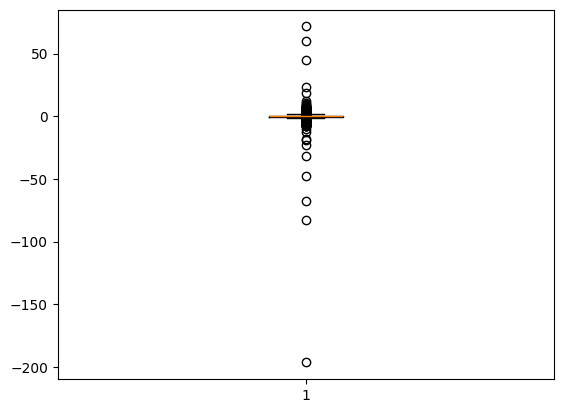

In [32]:
#box plot para ver la cantidad de ruido en los datos --> la columna 948 tiene MUCHO ruido (las mas ruidosas son: '948.8057', '916.0217', '2335.373')

box = buenos_savgol_11_SVD.drop(columns=columnas_grupo)
# box  = box.drop(columns = ['948.8057'])
# , '916.0217', '2335.373'
stdev= np.std(box, axis=0)/np.mean(box, axis=0)

print(box[stdev[stdev < -150].keys()])

for i, stdevpermean in enumerate(stdev):
    if stdevpermean > 500:
        print(i, stdevpermean)
plt.boxplot(stdev)

In [67]:
#Frobenius norm --> no se muy bien que hace. Cuanto menor el numerito mejor (menos cambian los datos antes y despues del SVD)

buenos_savgol_m = buenos_savgol.drop(columns=columnas_grupo)
buenos_savgol_SVD_m = buenos_savgol_SVD.drop(columns=columnas_grupo)
difference = buenos_savgol_m - buenos_savgol_SVD_m

norm_orig = np.linalg.norm(buenos_savgol_m) 


norm_diff = np.linalg.norm(difference) 

print(norm_diff)
print(norm_diff/norm_orig)

16.142514444865146
2.508008079590651


In [7]:
#seleccion de muestras en funcion de grupo, tiempo y tejido (PONER '-' PARA NO ESPECIFICAR CAMPO --> COGERÁ TODAS)

#finger print region --> "1801.188" - "1299.787"
#lipid region --> "3050.834" - "2798.205"
#protein region --> "1801.188" - "1498.419"

fingerprint_buenos = rango_panza(buenos_savgol, "1801.188", "1299.787")


IL6_BRWM = select_rows_by_criteria(fingerprint_buenos, 'IL6', '-', 'BR-WM')

IL6_BRGM = select_rows_by_criteria(fingerprint_buenos, 'IL6', '-', 'BR-GM')

IL6_CBWM = select_rows_by_criteria(fingerprint_buenos, 'IL6', '-', 'CB-WM')

IL6_CBGMM = select_rows_by_criteria(fingerprint_buenos, 'IL6', '-', 'CB-GMM')

IL6_CBGMG = select_rows_by_criteria(fingerprint_buenos, 'IL6', '-', 'CB-GMG')


dfs_to_join_wm = [IL6_CBWM,  IL6_BRWM]
dfs_to_join_gm = [IL6_CBGMG, IL6_CBGMM, IL6_BRGM]

IL6_WM = join_dfs(dfs_to_join_wm, 0)
IL6_GM = join_dfs(dfs_to_join_gm, 0)


# wt_br_and_cb_wm = join_dfs([wt_brwm, wt_cbwm])

IL6_WM['Tejido'] = 'WM'
IL6_GM['Tejido'] = 'GM'


# print(IL6_GM)
IL6 = join_dfs([IL6_WM, IL6_GM], 0)

In [105]:

# WT_BRWM_P0 = select_rows_by_criteria(buenos_savgol_SVD, 'WT', 'P0', 'BR-WM')
# WT_BRWM_P7 = select_rows_by_criteria(buenos_savgol_SVD, 'WT', 'P7', 'BR-WM')
# WT_BRWM_P14 = select_rows_by_criteria(buenos_savgol_SVD, 'WT', 'P14', 'BR-WM')
# WT_BRWM_P21 = select_rows_by_criteria(buenos_savgol_SVD, 'WT', 'P21', 'BR-WM')
# WT_BRWM_P28 = select_rows_by_criteria(buenos_savgol_SVD, 'WT', 'P28', 'BR-WM')

WT_BRWM = select_rows_by_criteria(buenos_savgol_7_SVD, 'WT', '-', 'BR-WM')

lipid_WT_CBWM = rango_panza(WT_BRWM, "3050.834", "2798.205")
# protein_WT_CBGMM = rango_panza(WT_CBGMM, "1801.188" , "1498.419")
# fingerprint_WT_CBGMM = rango_panza(WT_CBGMM, "1801.188", "1299.787")

#lipid_WT_BR_SVD = rango_panza(WT_BR_SVD, "3050.834", "2798.205")


#Ya he conseguido crear un dataframe con todos los datos de un file (eso es, medidas mas especificaciones de muestra aka grupo etc)

#Ahora lo siguiente seria, por un lado, conseguir hacer un dataframe enorme en el que se junten muchos files; 
#Tambien he de conseguir iterar sobre todos los files de un directorio, para no ir uno por uno
    #DONE

#y por otro lado, empezar con el procesamiento de los datos (columna 1656(DONE), y luego lo del scattering la panxa y estas polladas)


#Y por ultimo tendria que hacer una funcion para escribir de nuevo los dataframes en el formato ascii.
    #DONE


#Ahora queremos representar los datos para ver la panza. Para eso tenemos que coger el rango que va de 2000(2001.749) a 1800 (1799.26). 
    #Para ello primero cojo la porcion de df que quiero representar (eso es entre ese rango y solo la muestra que se que esta mal, o
    # todas si es que se puede). Luego defino un nuevo df, que tendra dos columnas, x (los indices de las columnas del rango que
    # voy a representar) e y (las medidas de la muestra que quiero representar). ya eso lo represento en un lineplot.

#DONE 


#ahora tengo que aplicar el savgol filtering y ver si coinciden los resultados aqui con los del unscr.
    #si coinciden de locos, si no caca.


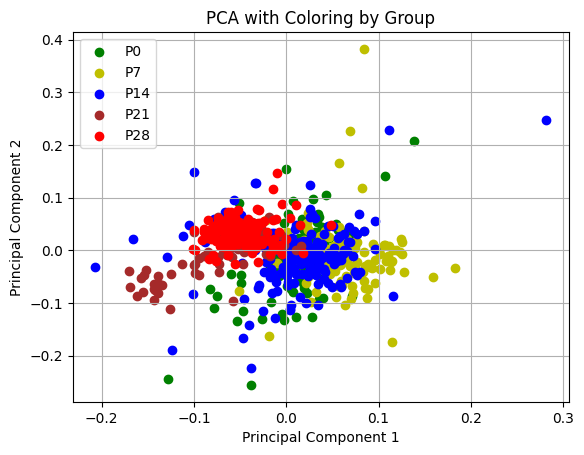

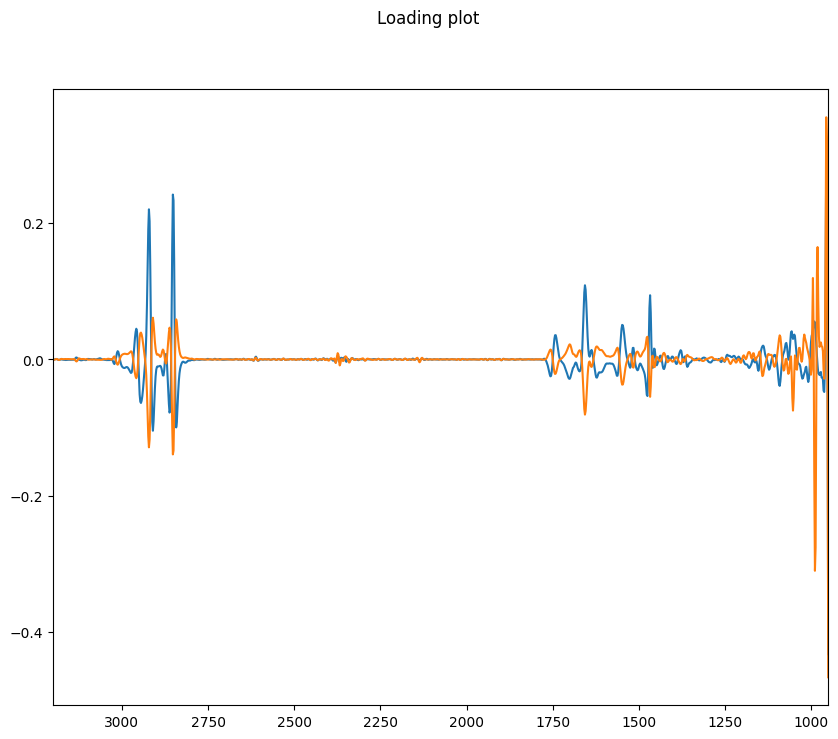

3050.834


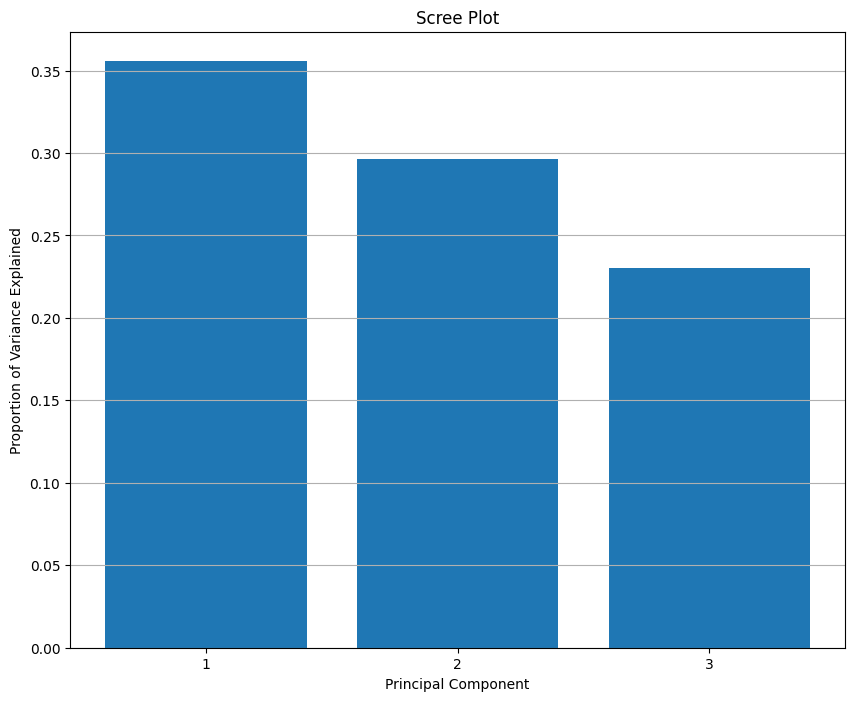

0.3557625803739186


In [109]:
#PCA

pca = PCA(3)
dataforpca =WT_BRWM

columnas_grupo = ['Grupo', 'Tejido', 'Tiempo', 'Muestra']
datos_grupos = dataforpca[columnas_grupo]
datos = dataforpca.drop(columns=columnas_grupo)


pca_result= pca.fit_transform(datos)

#colors1 = {'P0':'g', 'P7':'y', 'P14':'b', 'P21': 'brown', 'P28':'r' }
#colors2 = {'CB-WM':'g', 'CB-GMG':'y', 'CB-GMM':'b', 'BR-WM': 'brown', 'BR-GM':'r' }

colors = {'P0':'g', 'P7':'y', 'P14':'b', 'P21': 'brown', 'P28':'r' }
#colors = { 'BR-WM': 'b', 'BR-GM':'r' }

for group, color in colors.items():
    indices = datos_grupos['Tiempo'] == group
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], c=color, label=group)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with Coloring by Group')
plt.legend()
plt.grid(True)
plt.show()

#LOADINGS

loadings = pca.components_

data_loading = dataforpca.drop(columns=columnas_grupo)

rango=data_loading.columns.to_list()

#rango = rango[4:]

pc1 = loadings[0].tolist()

pc2 = loadings[1].tolist()
rango_loading = []
for i in rango:
    rango_loading.append(float(i))

fig, ax = plt.subplots(1, figsize = (10,8))

fig.suptitle('Loading plot')
ax.plot(rango_loading, pc1)
ax.plot(rango_loading, pc2)

ax.set_xlim(rango_loading[0], rango_loading[-1])



plt.show()





print(rango_loading[77])

scree = pca.explained_variance_ratio_
plt.figure(figsize=(10, 8))
plt.bar(np.arange(1, len(scree) + 1), scree, align='center')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(np.arange(1, len(scree) + 1))
plt.grid(axis='y')
plt.show()
print(scree[0])


In [82]:
#sacar que bandas son las que mas contribuyen en el PCA

loadings_list = loadings.tolist()
loadings_list.sort()
ind_max = loadings_list[0].index(min(loadings_list[0]))
ind_min = loadings_list
print(rango_loading[ind_max])

2921.627


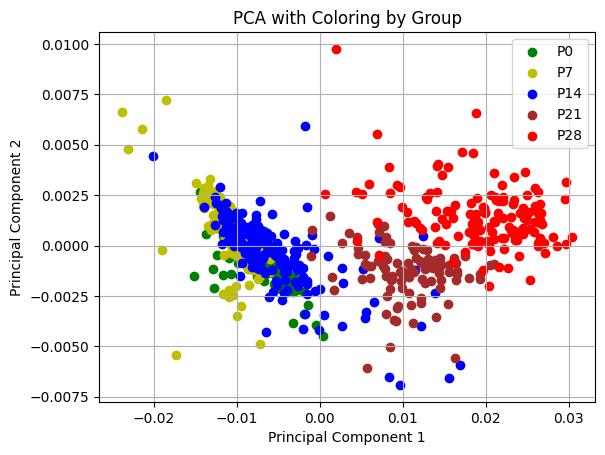

In [38]:
pca = PCA(3)
lipid_WT_BRWM_SVD = rango_panza(WT_BRWM_SVD, "3050.834", "2798.205")
dataforpca =lipid_WT_BRWM

columnas_grupo = ['Grupo', 'Tejido', 'Tiempo', 'Muestra']
datos_grupos = dataforpca[columnas_grupo]
datos = dataforpca.drop(columns=columnas_grupo)


pca_result= pca.fit_transform(datos)

#colors1 = {'P0':'g', 'P7':'y', 'P14':'b', 'P21': 'brown', 'P28':'r' }
#colors2 = {'CB-WM':'g', 'CB-GMG':'y', 'CB-GMM':'b', 'BR-WM': 'brown', 'BR-GM':'r' }

colors = {'P0':'g', 'P7':'y', 'P14':'b', 'P21': 'brown', 'P28':'r' }
#colors = { 'BR-WM': 'b', 'BR-GM':'r' }

for group, color in colors.items():
    indices = datos_grupos['Tiempo'] == group
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], c=color, label=group)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with Coloring by Group')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
#FURTHER ANALYSIS

#regiones
    #CH2 asymmetric stretching vibrations: "2923.556","2921.627","2919.699"
    #CH3 asymmetric stretching vibrations: "2964.053","2962.125","2960.197"
    #C=CH, unsaturated olefinic group: "3014.194","3012.265","3010.337"
    #C=O, carbonyl group: "1745.262","1743.334","1741.406"
    
    #alfa-helix protein structure: "1658.481","1656.553","1654.625"
    #intramolecular beta-sheet protein structure: "1639.197","1637.268","1635.34"
    #intermolecular beta-sheet protein structure: "1627.626","1625.698","1623.769"
    #Amide II: "1550.487","1548.559","1546.63"

ids = buenos_savgol[columnas_grupo]
ch2_reg = ["2923.556","2921.627","2919.699"]
ch3_reg = ["2964.053","2962.125","2960.197"]
c_ch_reg = ["3014.194","3012.265","3010.337"]
c_o_reg = ["1745.262","1743.334","1741.406"]
alfa_helix_reg = ["1658.481","1656.553","1654.625"]
intra_beta_reg = ["1639.197","1637.268","1635.34"]
inter_beta_reg = ["1627.626","1625.698","1623.769"]
amide_II_reg = ["1550.487","1548.559","1546.63"]


ch2 = buenos_savgol[ch2_reg]
mean_ch2 = ch2.mean(axis=1)
ch2['CH2'] = mean_ch2
ch2 = ch2.drop(columns=ch2_reg)


ch3 = buenos_savgol[ch3_reg]
mean_ch3 = ch3.mean(axis=1)
ch3['CH3'] = mean_ch3
ch3 = ch3.drop(columns=ch3_reg)


c_ch = buenos_savgol[c_ch_reg]
mean_c_ch = c_ch.mean(axis=1)
c_ch['C=CH'] = mean_c_ch
c_ch = c_ch.drop(columns=c_ch_reg)


c_o = buenos_savgol[c_o_reg]
mean_c_o = c_o.mean(axis=1)
c_o['C=O'] = mean_c_o
c_o = c_o.drop(columns=c_o_reg)


alfa_helix = buenos_savgol[alfa_helix_reg]
mean_alfa_helix = alfa_helix.mean(axis=1)
alfa_helix['Alpha-helix'] = mean_alfa_helix
alfa_helix= alfa_helix.drop(columns=alfa_helix_reg)


intra_beta = buenos_savgol[intra_beta_reg]
mean_intra_beta = intra_beta.mean(axis=1)
intra_beta['Intramolecular Beta-sheet'] = mean_intra_beta
intra_beta = intra_beta.drop(columns=intra_beta_reg)


inter_beta = buenos_savgol[inter_beta_reg]
mean_inter_beta = inter_beta.mean(axis=1)
inter_beta['Intermolecular Beta-sheet'] = mean_inter_beta
inter_beta = inter_beta.drop(columns=inter_beta_reg)


amide_II = buenos_savgol[amide_II_reg]
mean_amide_II = amide_II.mean(axis=1)
amide_II['Amide II'] = mean_amide_II
amide_II = amide_II.drop(columns=amide_II_reg)


dfs_to_join = [ids, ch2, ch3, c_ch, c_o, alfa_helix, inter_beta, intra_beta, amide_II]

peaks_interest = join_dfs(dfs_to_join, 1)

print(peaks_interest)

peaks_interest['CH3'] = peaks_interest['CH3'] / peaks_interest['CH2']
peaks_interest['C=CH'] = peaks_interest['C=CH'] / peaks_interest['CH2']
peaks_interest['C=O'] = peaks_interest['C=O'] / peaks_interest['CH2']

peaks_interest['Intramolecular Beta-sheet'] = peaks_interest['Intramolecular Beta-sheet'] / peaks_interest['Alpha-helix']
peaks_interest['Intermolecular Beta-sheet'] = peaks_interest['Intermolecular Beta-sheet'] / peaks_interest['Alpha-helix']
peaks_interest['Amide II'] = peaks_interest['Amide II'] / peaks_interest['Alpha-helix']

print(peaks_interest)

                     Grupo Tejido Tiempo Muestra       CH2       CH3  \
IL10_BR-GM_P0_N227#0  IL10  BR-GM     P0    N227 -0.002292 -0.001163   
IL10_BR-GM_P0_N227#1  IL10  BR-GM     P0    N227 -0.002434 -0.001008   
IL10_BR-GM_P0_N227#2  IL10  BR-GM     P0    N227 -0.002511 -0.000939   
IL10_BR-GM_P0_N227#3  IL10  BR-GM     P0    N227 -0.002315 -0.000910   
IL10_BR-GM_P0_N227#4  IL10  BR-GM     P0    N227 -0.002648 -0.000970   
...                    ...    ...    ...     ...       ...       ...   
WT_CB-WM_P7_N249#43     WT  CB-WM     P7    N249 -0.003095 -0.000920   
WT_CB-WM_P7_N249#44     WT  CB-WM     P7    N249 -0.003444 -0.001320   
WT_CB-WM_P7_N249#45     WT  CB-WM     P7    N249 -0.002735 -0.000740   
WT_CB-WM_P7_N249#46     WT  CB-WM     P7    N249 -0.002769 -0.000630   
WT_CB-WM_P7_N249#47     WT  CB-WM     P7    N249 -0.002829 -0.000729   

                          C=CH       C=O  Alpha-helix  \
IL10_BR-GM_P0_N227#0 -0.000080 -0.000580    -0.007803   
IL10_BR-GM_P0_N227#1 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_29872\4127693698.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch2['CH2'] = mean_ch2
C:\Users\Usuario\AppData\Local\Temp\ipykernel_29872\4127693698.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ch3['CH3'] = mean_ch3
C:\Users\Usuario\AppData\Local\Temp\ipykernel_29872\4127693698.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i